In [1]:
import pandas as pd
import numpy as np
import time

import scanpy as sc
from anndata.experimental.pytorch import AnnLoader

import pretty_confusion_matrix as pcm

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchnet.meter import ClassErrorMeter, AverageValueMeter
# from torch_prototypes.modules import prototypical_network
import prototypical_network
from torch_prototypes.metrics import distortion, cost
from torch_prototypes.metrics.distortion import DistortionLoss
from  torch.distributions import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

import helper_fns
import vanilla_vae

import igraph as ig
from sklearn.decomposition import TruncatedSVD
from anndata import AnnData

In [2]:
dataset = sc.read('filtered_data_500.h5ad')
dataset_raw = dataset
dataset.raw = dataset_raw
encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset.obs['Manually_curated_celltype'])
encoders = {
    'obs': {
        'Manually_curated_celltype': encoder_celltype.transform
    }
}
train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset, cross_validation=False, k_fold=5)
sc.pp.normalize_total(dataset, 1e4)
sc.pp.log1p(dataset)
pca = TruncatedSVD(n_components=128)
pca.fit(dataset[train_indices].X)
dataset_pca = AnnData(pca.transform(dataset.X))
dataset_pca.raw = dataset_raw
dataset_pca.obs = dataset.obs
dataset = dataset_pca

train_loader = AnnLoader(dataset[train_indices], batch_size=dataset.shape[0], shuffle=True, convert=encoders)
test_loader = AnnLoader(dataset[test_indices], batch_size=dataset.shape[0], shuffle=True, convert=encoders)
for batch in train_loader:
    X_train = batch.X
    y_train = batch.obs['Manually_curated_celltype']
for batch in test_loader:
    X_test = batch.X
    y_test = batch.obs['Manually_curated_celltype']

train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Define data loaders for training and testing data in this fold
dataloader_training = AnnLoader(dataset, batch_size=512, convert=encoders, sampler=train_subsampler)
dataloader_testing = AnnLoader(dataset, batch_size=512, convert=encoders, sampler=test_subsampler)

In [7]:
# Pytorch version of the 3 fully connected layers
class Net(nn.Module):
    def __init__(self, mode, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.mode = mode
        self.fc1 = nn.Linear(input_size, hidden_size)
        if mode == 'Net':
            self.fc2 = nn.Linear(hidden_size, output_size)
        else:
            self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
def train(mode, epochs=30, cuda=1):
    model = Net(mode, 128, 32, 37).cuda()
    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    for epoch in range(1, epochs+1):
        print('Epoch {}'.format(epoch))
        ER_meter = ClassErrorMeter(accuracy=False)

        model.train()
        t0 = time.time()
        for batch in dataloader_training:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            out = model(x)
            opt.zero_grad()
            loss = criterion(out, y)
        
            loss.backward()
            opt.step()
            pred = out.detach()
            ER_meter.add(pred.cpu(),y.cpu())
        t1 = time.time()
        
        print('Train ER {:.2f}, time {:.1f}s'.format(ER_meter.value()[0], t1-t0))

        model.eval()
        ER_meter = ClassErrorMeter(accuracy=False)
        t0 = time.time()
        for batch in dataloader_testing:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            with torch.no_grad():
                out = model(x)
            pred = out.detach()
            ER_meter.add(pred.cpu(),y)
        t1 = time.time()
        print('Test ER {:.2f}, time {:.1f}s'.format(ER_meter.value()[0], t1-t0))
    return model

In [9]:
model = train(mode='Net')

Epoch 1
Train ER 61.93, time 0.6s
Test ER 25.67, time 0.1s
Epoch 2
Train ER 17.07, time 0.6s
Test ER 12.83, time 0.1s
Epoch 3
Train ER 11.87, time 0.4s
Test ER 11.04, time 0.1s
Epoch 4
Train ER 10.35, time 0.4s
Test ER 10.57, time 0.1s
Epoch 5
Train ER 9.76, time 0.5s
Test ER 10.12, time 0.1s
Epoch 6
Train ER 9.36, time 0.4s
Test ER 9.81, time 0.1s
Epoch 7
Train ER 9.03, time 0.4s
Test ER 9.74, time 0.2s
Epoch 8
Train ER 8.87, time 0.4s
Test ER 9.65, time 0.1s
Epoch 9
Train ER 8.76, time 0.4s
Test ER 9.68, time 0.1s
Epoch 10
Train ER 8.59, time 0.6s
Test ER 9.76, time 0.1s
Epoch 11
Train ER 8.44, time 0.4s
Test ER 9.61, time 0.1s
Epoch 12
Train ER 8.40, time 0.4s
Test ER 9.53, time 0.1s
Epoch 13
Train ER 8.29, time 0.5s
Test ER 9.71, time 0.1s
Epoch 14
Train ER 8.26, time 0.4s
Test ER 9.74, time 0.1s
Epoch 15
Train ER 8.17, time 0.5s
Test ER 9.51, time 0.1s
Epoch 16
Train ER 8.16, time 0.4s
Test ER 9.48, time 0.1s
Epoch 17
Train ER 8.04, time 0.4s
Test ER 9.56, time 0.1s
Epoch 18
Train

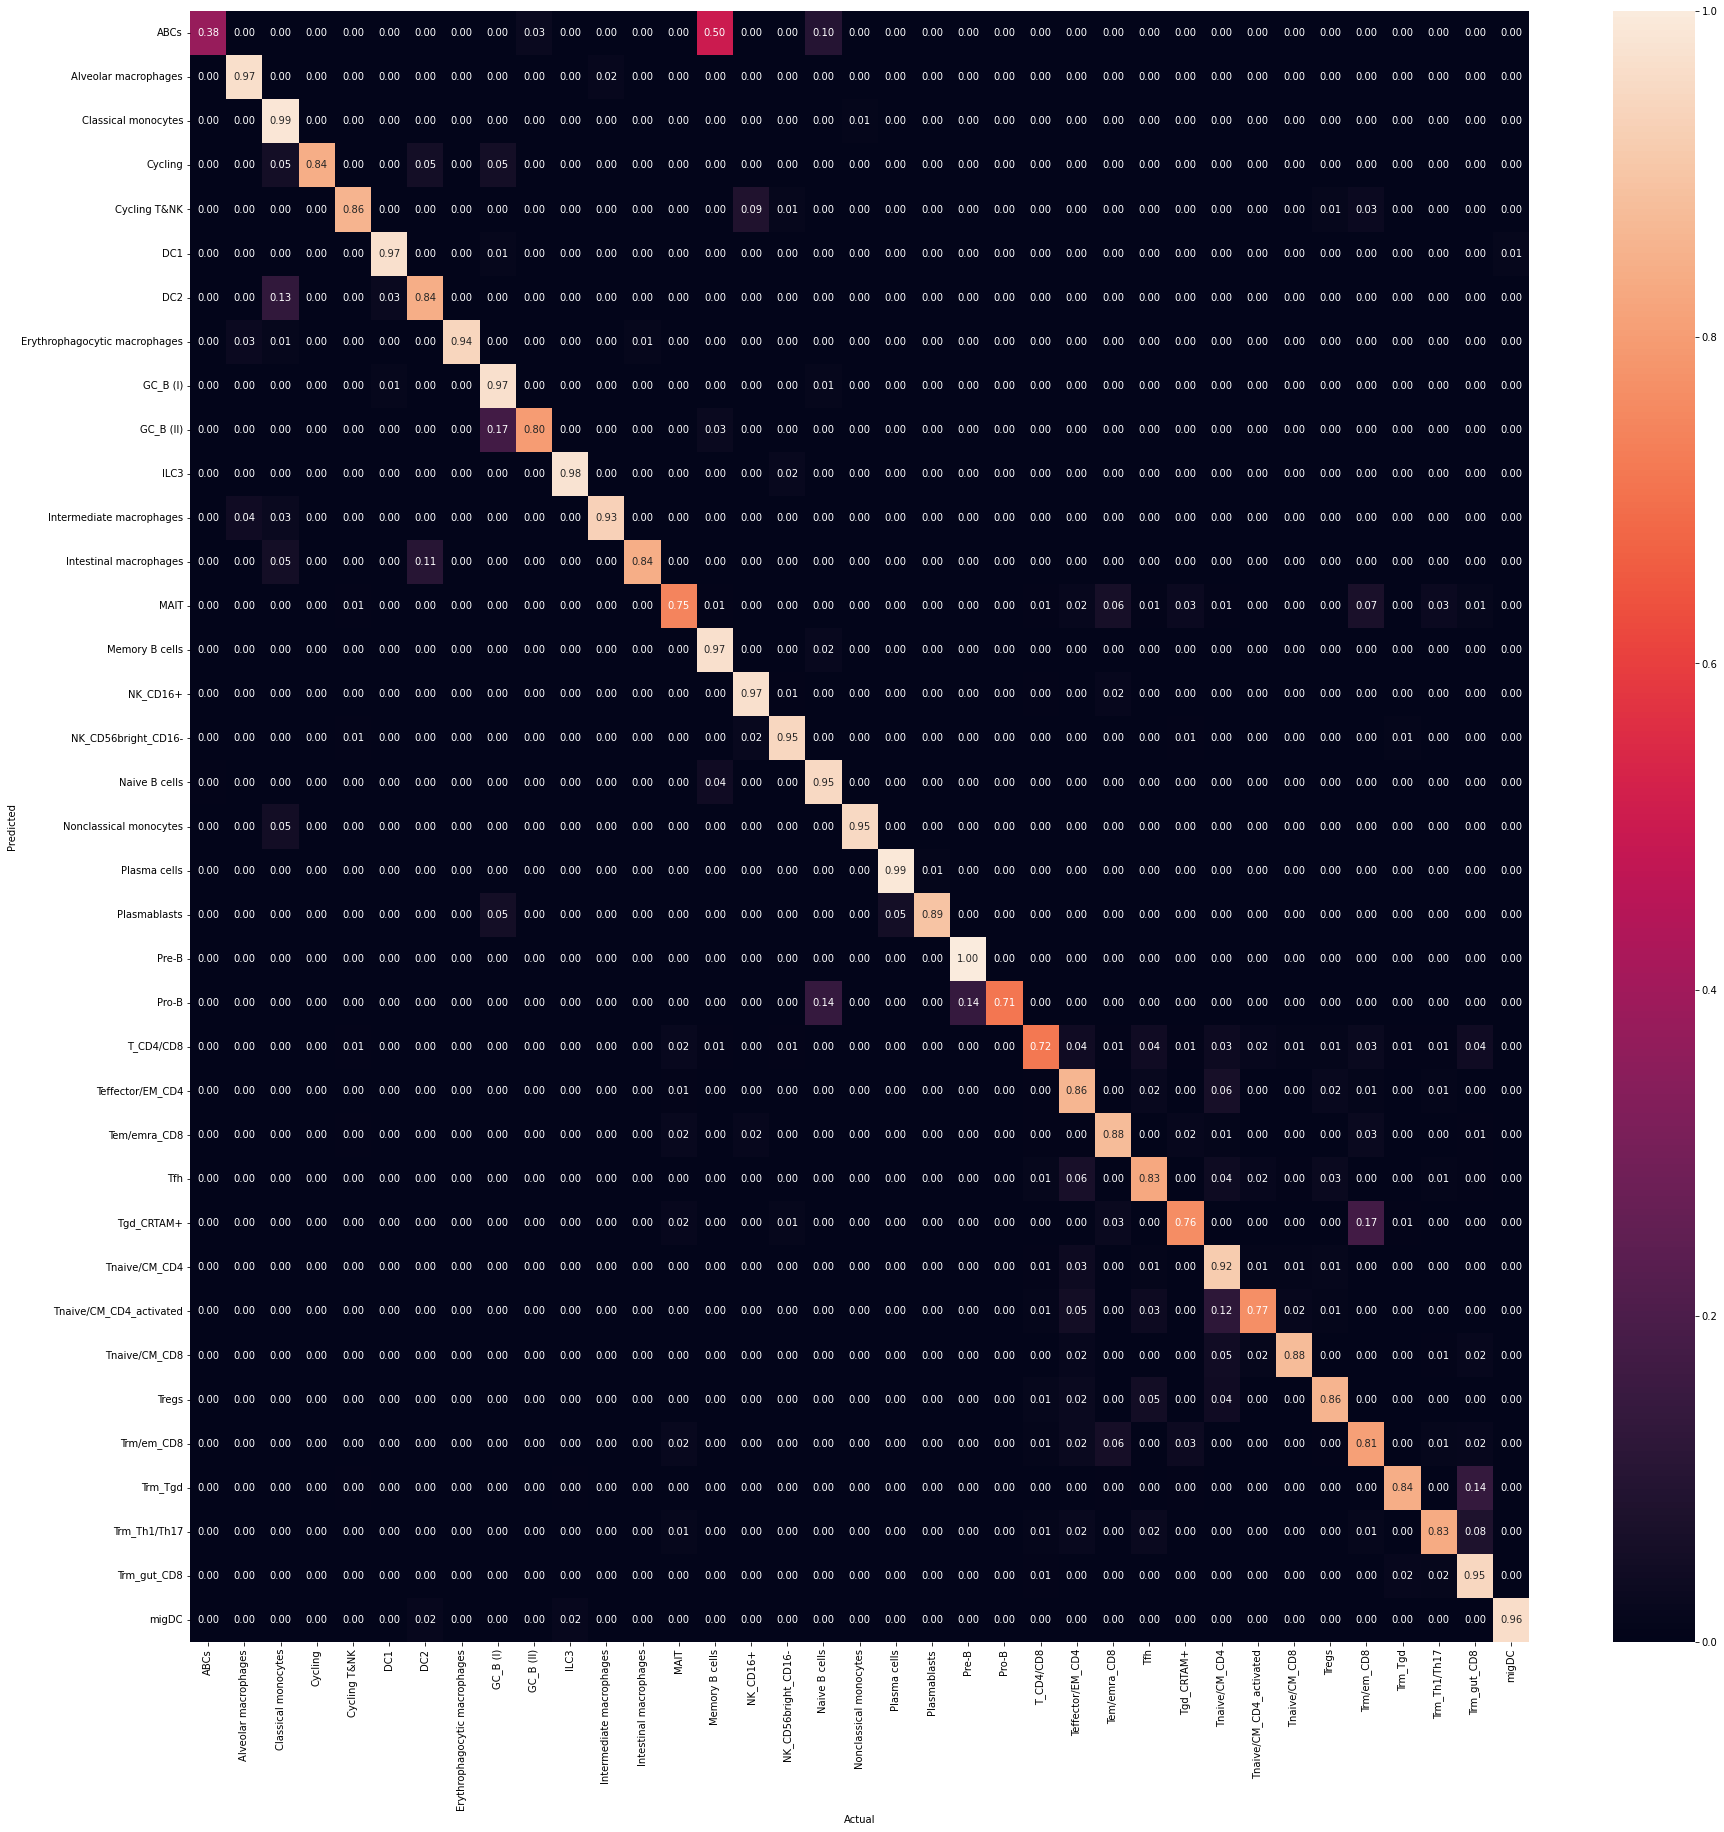

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test = dataset[test_indices].obs['Manually_curated_celltype']
y_pred = model(torch.tensor(dataset[test_indices].X).cuda()).detach().cpu().numpy()
pred = encoder_celltype.inverse_transform(y_pred.argmax(axis=1))
cm=confusion_matrix(y_test, pred)
# Normalise
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))),
                                    yticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show(block=False)